# Run Test-Time Simulation with Multiple Reward Model

In [6]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import yaml 

In [7]:
'---- Load the computed reward scores of each prompt, each image and each timestep ---'
value_folder = 'values'
diffusion_model = 'flux' # flux or sdxl
reward_models = ['imr', 'pic', 'hps'] # imr or pic or hps
num_prompt = 200 # number of prompts to use
num_image = 200 # number of images per prompt
num_steps = 20 # number of diffusion inference timesteps

def load_reward_values(value_folder, diffusion_model, reward_model, num_prompt, num_image, num_steps):
    reward_base_all = []  # shape (num_prompt, num_image, num_steps)
    reward_naft_all = [] # shape (num_prompt, num_image, num_steps)

    location_base = f'{value_folder}/{diffusion_model}_{reward_model}_val_base'
    for s in np.arange(num_steps):
        file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
        r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
        reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
        reward_base_all.append(reward_one_step)
    reward_base_all = np.stack(reward_base_all, axis=-1) # shape (num_prompt, num_image, num_steps)
    print(f'Loaded base reward scores of {reward_model} with shape: {reward_base_all.shape}')

    location_naft = f'{value_folder}/{diffusion_model}_{reward_model}_val_naft'
    for s in np.arange(num_steps):
        file_name = f'p{num_prompt}_i{num_image}_s{s:02d}.yaml'
        if not os.path.exists(f'{location_naft}/{file_name}'):
            # some steps are not used for naft and we use base values instead, e.g. steps too high or too low
            r_dict = yaml.safe_load(open(f'{location_base}/{file_name}')) 
        else:
            r_dict = yaml.safe_load(open(f'{location_naft}/{file_name}')) 
        reward_one_step = np.stack([r_dict[k] for k in sorted(r_dict.keys())], axis=0) # shape (num_prompt, num_image)
        reward_naft_all.append(reward_one_step)
    reward_naft_all = np.stack(reward_naft_all, axis=-1) # shape (num_prompt, num_image, num_steps)

    print(f'Loaded naft reward scores of {reward_model} with shape: {reward_naft_all.shape}')
    return reward_base_all, reward_naft_all


reward_base_all_ = []
reward_naft_all_ = []
for reward_model in reward_models:
    reward_base_all, reward_naft_all = load_reward_values(
        value_folder, diffusion_model, reward_model, num_prompt, num_image, num_steps
    )
    reward_base_all_.append(reward_base_all)
    reward_naft_all_.append(reward_naft_all)

reward_base_all = np.stack(reward_base_all_, axis=-1) # shape (num_prompt, num_image, num_steps, num_reward_models)
reward_naft_all = np.stack(reward_naft_all_, axis=-1) # shape (num_prompt, num_image, num_steps, num_reward_models)
print(f'Final base reward scores shape: {reward_base_all.shape}')
print(f'Final naft reward scores shape: {reward_naft_all.shape}')
    

Loaded base reward scores of imr with shape: (200, 200, 20)
Loaded naft reward scores of imr with shape: (200, 200, 20)
Loaded base reward scores of pic with shape: (200, 200, 20)
Loaded naft reward scores of pic with shape: (200, 200, 20)
Loaded base reward scores of hps with shape: (200, 200, 20)
Loaded naft reward scores of hps with shape: (200, 200, 20)
Final base reward scores shape: (200, 200, 20, 3)
Final naft reward scores shape: (200, 200, 20, 3)


In [8]:
from ttsnap_sim import *

In [ ]:
def postprocess_reward(value, reward_model):
    # do some postprocessing based on the reward model if needed
    if reward_model == 'imr':
        value = ( value - 0.16717362830052426 )/  1.0333394966054072
    elif reward_model == 'hps':
        value = value * 100
    return value

In [13]:
'Compare TTSnap, TTSp and Best-of-N'

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget = 2000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

# Best-of-N
n = int(budget / S.bon_cost())
print('Number of images seen in Best-of-N:', n)
r_bon, _ = S.bon_run(reward_base_all[:,:,-1, :], image_num_use=n, iters=iters, use_multi=True)

# TTsnap
alphas = [0.4, 0.5, 0.6] # hyperparameters
steps_use = [4, 6, 11] # hyperparameters
n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
print('Number of images seen in TTsnap:', n)
r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, 
        steps_use=steps_use, iters=iters, use_multi=True)

r_bon = [postprocess_reward(r_bon[i], reward_models[i]).item() for i in range(len(reward_models))]
print('Averaged reward Best-of-N of all the prompts:', r_bon)
r_ttsp = [postprocess_reward(r_ttsp[i], reward_models[i]).item() for i in range(len(reward_models))]
print('Averaged reward TTsnap of all the prompts:', r_ttsp) 

Number of images seen in Best-of-N: 10
Number of images seen in TTsnap: 28
Averaged reward Best-of-N of all the prompts: [1.2860524094879433, 21.981531822204595, 28.838756933808323]
Averaged reward TTsnap of all the prompts: [1.3246741357623155, 22.13804600596428, 29.06315872836858]


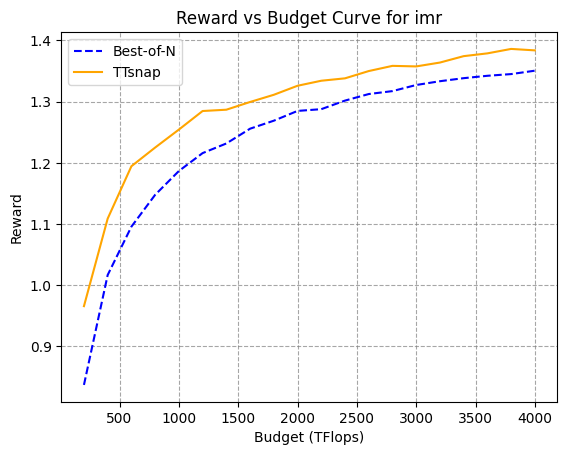

relative increase: 12.71%


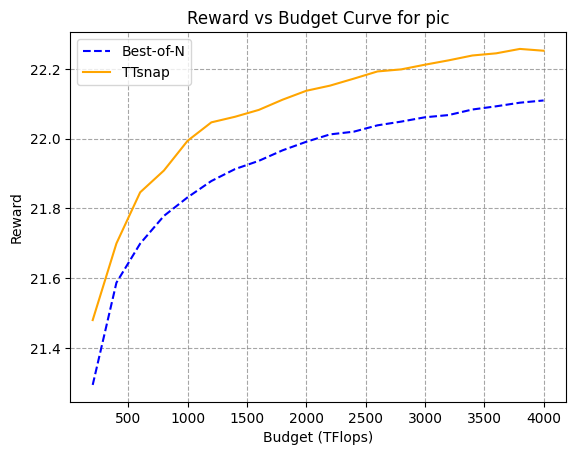

relative increase: 22.98%


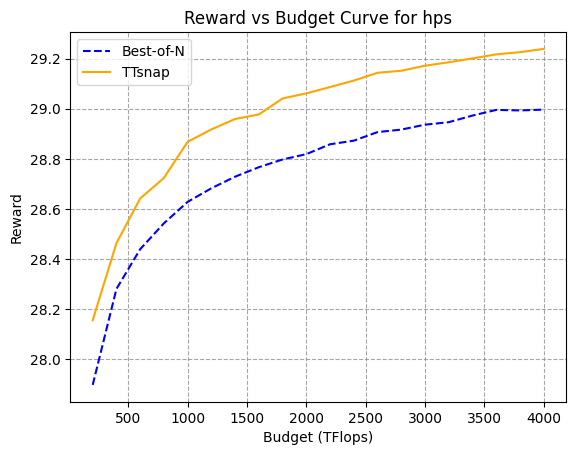

relative increase: 25.92%


In [15]:
'Plot and evaluation under different budgets settings'
from scipy import integrate
from matplotlib import pyplot as plt

denoise_budget = 9.9 # TFlops
verifier_budget = 1.2 # TFlops

budget_start = 200 
budget_end = 4000 
iters = 40

S = Simulation(x=denoise_budget, y=verifier_budget, max_step=num_steps)

results_bon = []
results_ttsp = []
for budget in range(budget_start, budget_end+1, 200):
    # Best-of-N
    n = int(budget / S.bon_cost())
    r_bon, _ = S.bon_run(reward_base_all[:,:,-1,:], image_num_use=n, iters=iters, use_multi=True)
    r_bon = [postprocess_reward(r_bon[i], reward_models[i]).item() for i in range(len(reward_models))] # ~~
    results_bon.append(r_bon)

    # TTsnap
    alphas = [0.4, 0.5, 0.6] # hyperparameters
    steps_use = [4, 6, 11] # hyperparameters
    n = int(budget / S.ttsp_cost(alpha_s=alphas, steps_use=steps_use))
    r_ttsp, _ = S.ttsp_run(reward_naft_all, image_num_use=n, alpha_s=alphas, 
        steps_use=steps_use, iters=iters, use_multi=True)
    r_ttsp = [postprocess_reward(r_ttsp[i], reward_models[i]).item() for i in range(len(reward_models))] # ~~
    results_ttsp.append(r_ttsp)

results_bon = np.stack(results_bon, axis=0) # shape (num_budgets, num_objectives)
results_ttsp = np.stack(results_ttsp, axis=0) # shape (num_budgets, num_objectives)




# Plot the reward vs budget curves
def plot_curve(budgets, rewards_out1, rewards_out2, label1, label2, reward_name):
    plt.plot(budgets, rewards_out1, label=label1, color='blue', linestyle='--')
    plt.plot(budgets, rewards_out2, label=label2, color='orange')
    plt.xlabel('Budget (TFlops)')
    plt.ylabel('Reward')
    plt.title(f'Reward vs Budget Curve for {reward_name}')
    plt.legend()
    plt.grid(linestyle='--', color='gray', alpha=0.7)
    plt.show()
    plt.close()


def evaluate(budgets, rs, rs_base):
    # rs: PTTS
    # rs_base: TTS
    assert len(budgets) == len(rs) == len(rs_base), "Lengths must match."
    assert (np.arange(len(budgets))==np.argsort(budgets)).all(), "Budgets must be sorted in ascending order."
    y0 = np.array(rs_base)[0]
    y_rs = np.array(rs) - y0
    y_rs_base = np.array(rs_base) - y0
    area1 = integrate.simpson(y=y_rs, x=budgets)
    area2 = integrate.simpson(y=y_rs_base, x=budgets)
    increase = (area1 - area2) / area2 if area2 != 0 else float('inf')
    increase = np.round(100*increase, 2)
    print(f'relative increase: {increase.item()}%')

budgets = list(range(budget_start, budget_end+1, 200))
for i in range(len(reward_models)):
    plot_curve(budgets, results_bon[:,i], results_ttsp[:,i], label1='Best-of-N', label2='TTsnap', reward_name=reward_models[i])
    omega = evaluate(budgets, results_ttsp[:,i], results_bon[:,i])